In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Figures from the paper
island_fig = cv.imread('images/fig5.png')
butterfly_fig = cv.imread('images/fig7.png')
dolphin_fig = cv.imread('images/fig8.png')
bench_fig = cv.imread('images/fig8-2008.png')
car_fig = cv.imread('images/fig9-2008.png')

In [3]:
#This will store the cumulative minimum energy matrix
min_energy = []

#This will store which pixels have been allocated to seams already
reserved_pixels = []

#Get the seam paths for each column in order from most optimal -> least optimal
ordered_seam_paths = []

heatmap_generated = False

forward = True

In [4]:
#Currently not in use!
def get_scharr(image):
    
    #https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaa13106761eedf14798f37aa2d60404c9
    
    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    scale = -1
    delta = 0
    ddepth = cv.CV_64F #What is this?

    #Add gradient to image first??
    #Remove noise by blurring with a Gaussian filter ( kernel size = 3 )
    #GaussianBlur(image, src, Size(3, 3), 0, 0, BORDER_DEFAULT);

    scharr_dx = cv.Scharr(image, ddepth, 1, 0, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    scharr_dy = cv.Scharr(image, ddepth, 0, 1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_scharr_dx = cv.convertScaleAbs(scharr_dx)
    abs_scharr_dy = cv.convertScaleAbs(scharr_dy)
    
    #abs_scharr_dx = np.abs(scharr_dx)
    #abs_scharr_dy = np.abs(scharr_dy)

    #scharr_out = cv.addWeighted(abs_scharr_dx, 0.5, abs_scharr_dy, 0.5, 0)
    scharr_out = abs_scharr_dx + abs_scharr_dy
    
    return scharr_out

In [5]:
#Convert an image back to RGB and display it
def display_image(image):
    plt.figure(dpi = 100)
    plt.axis('off')
    plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

In [6]:
#Draws the seam starting from (last row,start column) and following the seam path upwards
#Assumes color image with 3 channels in BGR format as input
last_seam_color = [0,0,255]

def draw_seam(image, seam_path):
    
    rows = len(image)
    i = rows-1
        
    for k in range(0,rows):
        
        image[i][seam_path[k]] = last_seam_color #Color pixel red
        i -= 1 #Move up a row
        
    #Attempt to colorize to see what is happening
#     last_seam_color[2] -= 2
#     last_seam_color[1] += 2
        
    return image

In [7]:
def draw_seams(image):
    
    seam_count = len(ordered_seam_paths)
        
    for i in range(seam_count):
        image = draw_seam(image,ordered_seam_paths[i])
    
    #display_image(image)
    return image
        

In [8]:
def get_pixel_min_energy(image_dydx,rows,cols,i,j):
        
    pixel_energy = image_dydx[i][j]
    neighbors = []
    
    #If this pixel has been reserved by another seam, set it's cost as infinite
    #if(reserved_pixels[i][j] == 1):
    #    return np.Infinity
    
    #Recursively get cumulative min energy for north, northeast, northwest neighbors
    if(i-1 >= 0):
        
        #If this energy has not already been calculated, calculate it
        if(min_energy[i-1][j] < 0):
            n_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j)
            
        #Else, just look it up
        else:
            n_neighbor = min_energy[i-1][j]
            
        neighbors.append(n_neighbor)
        
        if(j+1 < cols):
            
            #If this energy has not already been calculated, calculate it
            if(min_energy[i-1][j+1] < 0):
                ne_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j+1)

            #Else, just look it up
            else:
                ne_neighbor = min_energy[i-1][j+1]
            
            neighbors.append(ne_neighbor)
            
        if(j-1 >=0):
            
            #If this energy has not already been calculated, calculate it
            if(min_energy[i-1][j-1] < 0):
                nw_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j-1)

            #Else, just look it up
            else:
                nw_neighbor = min_energy[i-1][j-1]
            
            neighbors.append(nw_neighbor)

    #Get minimum neighbor
    min_neighbor = 0
    
    for k in range(len(neighbors)):

        if(k == 0):
            min_neighbor = neighbors[0] #Set first neighbor because all neighbors > 0

        if(neighbors[k] < min_neighbor):
            min_neighbor = neighbors[k]

    min_cumulative_energy = pixel_energy + min_neighbor
    
    min_energy[i][j] = min_cumulative_energy

    return min_cumulative_energy
    

In [9]:
def calculate_min_energy(image_dydx):
    rows = len(image_dydx)
    cols = len(image_dydx[0])
    
    for i in range(1,rows): #skip first row
            
        for j in range(cols):
            
            min_energy[i][j] = get_pixel_min_energy(image_dydx,rows,cols,i,j)
            

In [10]:
def generate_heatmap(energy_map):
    
    min_energy_heatmap = np.copy(energy_map)
    max_energy = 0
    
    for i in range(energy_map.shape[0]):
        for j in range(energy_map.shape[1]):
            if(energy_map[i][j] != np.Infinity):
                if(energy_map[i][j] > max_energy):
                    max_energy = energy_map[i][j]
            
    min_energy_heatmap = np.multiply(min_energy_heatmap,(255.0/max_energy))
    min_energy_heatmap = min_energy_heatmap.astype(np.uint8)
    min_energy_heatmap = cv.applyColorMap(min_energy_heatmap,cv.COLORMAP_JET)
    
    display_image(min_energy_heatmap)
    
    cv.imwrite("heatmap_out_" + str(energy_map.shape[1]) + ".png",min_energy_heatmap)

In [11]:
def get_sobel(image):
    
    #https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html

    scale = 1
    delta = 0
    ddepth = cv.CV_64F

#     image = cv.GaussianBlur(image, (3, 3), 0, 0, cv.BORDER_DEFAULT);
    
    sobel_dx = cv.Sobel(image, ddepth, 1, 0, ksize=1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    sobel_dy = cv.Sobel(image, ddepth, 0, 1, ksize=1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_sobel_dx = cv.convertScaleAbs(sobel_dx)
    abs_sobel_dy = cv.convertScaleAbs(sobel_dy)

    #sobel_out = cv.addWeighted(abs_sobel_dx, 0.5, abs_sobel_dy, 0.5, 0)
    sobel_out = abs_sobel_dx + abs_sobel_dy
    
    return sobel_out

In [12]:
#Backtracks the seam from the given row and column building a list of indices
def backtrack_seam(seam_path,row,col,max_col):
    
    if(row > 0):
        direction = 0
        min_neighbor = min_energy[row-1][col] #North        
        
        if(col>0):
            nw_neighbor = min_energy[row-1][col-1]
            if(nw_neighbor < min_neighbor):
                min_neighbor = nw_neighbor
                direction = -1
        
        if(col<max_col):
            ne_neighbor = min_energy[row-1][col+1]
            if(ne_neighbor < min_neighbor):
                min_neighbor = ne_neighbor
                direction = 1
        
        next_col = seam_path[-1] + direction
        #reserved_pixels[row-1][next_col] = 1
        #min_energy[row-1][next_col] = np.Infinity
        seam_path.append(next_col)
        
        backtrack_seam(seam_path,row-1,col+direction,max_col)
        
    return seam_path

In [13]:
#Removes a vertical seam from the image and returns an image with one less column
def remove_seam_pixels(image, seam_path):
    
    rows = len(image)
    cols = len(image[0])
    i = rows-1
    cut_image = np.empty([rows, cols-1, 3],dtype=image.dtype)
    
    for n in range(cols):
    
        for m in range(rows):
        
            row_index = rows - (m+1)
            
            #if(n != col_to_cut):
            if(seam_path[row_index] < n):
                cut_image[m][n-1] = image[m][n]
            elif(n < cols-1):
                cut_image[m][n] = image[m][n]
    
    return cut_image

In [14]:
#Takes an image and removes 'seams_to_remove' seams from the image
def remove_seams(image, seams_to_remove):
    
    global heatmap_generated
        
    print("Seams Removed: ", end ='')
    
    for i in range(seams_to_remove):
        best_seam_path = carve_seam(image)
        image = remove_seam_pixels(image, best_seam_path)
        print(i,end='')
        
        if(i%25 == 0):
            filename = "removed_" + str(i) + ".png"
            cv.imwrite(filename,image)
            heatmap_generated = False   
                    
    display_image(image)
    return image
        

In [15]:
def get_pixel_average(left_pixel,right_pixel):
    
    r_avg = np.mean([left_pixel[0], right_pixel[0]])
    r_avg = r_avg.astype(np.uint8)
    
    g_avg = np.mean([left_pixel[1], right_pixel[1]])
    g_avg = g_avg.astype(np.uint8)
    
    b_avg = np.mean([left_pixel[2], right_pixel[2]])
    b_avg = b_avg.astype(np.uint8)
    
#     print([r_avg, g_avg, b_avg])
    return np.array([r_avg, g_avg, b_avg]) #DANGER could be an issue???

In [16]:
#Update all seam paths to account for insertion of collumns
def update_seam_paths():
    
    seam_count = len(ordered_seam_paths)
    path_length = len(ordered_seam_paths[0])
        
    #For each seam
    for i in range(seam_count):
                
        #For everyother seam after this seam
        for j in range(i+1,seam_count):
                    
            for k in range(path_length):

                #Only columns to the right of the changed seam should be affected
                if(ordered_seam_paths[i][k] < ordered_seam_paths[j][k]):

                    ordered_seam_paths[j][k] += 2 #One for the deleted seam and one for inserted seam        


In [17]:
#Inserts a vertical seam from the image and returns an image with one more column
def insert_seam(image, seam_path):
    
    #print(image)
    #display_image(image)
    
    rows = len(image)
    cols = len(image[0])
    i = rows-1    
    insert_image = []
    scaled_image = np.empty([image.shape[0],image.shape[1]+1,3], dtype=image.dtype)
    
    for m in range(rows):
        
        col_to_duplicate = seam_path[-1*(m+1)]
        offset = 0
        
        for n in range(cols):
            
            scaled_image[m][n+offset] = image[m][n]
            
            if(n == col_to_duplicate):
                
                offset += 1
                
                if(n+1<cols):
                    #print("left_pixel type = ", image[m][n].dtype)
                    pixel_average = get_pixel_average(image[m][n],image[m][n+1])
                    #print("pixel_average type = ", pixel_average.dtype)
                else:
                    pixel_average = image[m][n]

                scaled_image[m][n+offset] = pixel_average #DOUBLE CHECK HERE - add additional pixel
        
    return scaled_image

In [18]:
#Takes an image and adds 'seams_to_add' seams to the image
def add_seams(image, seams_to_add):
    
    #Carve the seams using remove seams for the number of seams needed
    #This will generate the list of seam paths in order
    
    display_image(image)
    
    image_to_cut = np.copy(image)
    print("image_to_cut.dtype= ",image_to_cut.dtype)
    print("image.dtype= ",image.dtype)
    
    cut_image = remove_seams(image_to_cut,seams_to_add)
    display_image(cut_image)
    
    #Update the seam paths so that they will map into the original image properly
    update_seam_paths()
    
    for i in range(seams_to_add):
        image = insert_seam(image, ordered_seam_paths[i])
        
    display_image(image)
        
    return image   
    

In [19]:
#Takes an image and returns an ordered list of columns and their seam paths
def carve_seam(image):
    
    global min_energy
    global heatmap_generated
    global forward
    
    #Get sobel image with dy dx of image
    sobel_image = get_sobel(image)
    sobel_image = cv.cvtColor(sobel_image, cv.COLOR_BGR2GRAY)
    #display_image(sobel_image)
    
    rows = image.shape[0]
    cols = image.shape[1]
    
    #Initialize a matrix with -1's to store cumulative minimum energies
    min_energy = np.empty_like(sobel_image,np.float64)-1
    reserved_pixels = np.empty_like(sobel_image,np.float64)
    
    #Calculate the cumulative minimum energy of each pixel 
    if(forward):
        min_energy = calc_forward_energy(image,sobel_image)
        #print("min energy:",min_energy[:,0])
    else:
        calculate_min_energy(sobel_image)
    
    #Get the sorted order of column indices (index of lowest column val -> index of highest)
    seam_order = np.argsort(min_energy[-1])
    
    if(not heatmap_generated):
        generate_heatmap(min_energy)
        heatmap_generated = True
    
    #Get seam path for the min column by backtracking cumulative min. energies
    
    best_seam_path = backtrack_seam([seam_order[0]],rows-1,seam_order[0],cols-1)
    #reserved_pixels[rows-1][seam_order[seams_carved]] = 1
    #min_energy[rows-1][seam_order[seams_carved]] = np.Infinity
    #print(best_seam_path)
    ordered_seam_paths.append(best_seam_path)
        
#     cut_image = remove_seam_pixels(image,best_seam_path)
    
#     display_image(cut_image)
    
#     return cut_image
    return best_seam_path

In [20]:
#Carve all the seams of an image and store their paths
def carve_seams(image,seams_to_carve):
    
    global min_energy
    global reserved_pixels
    global heatmap_generated
        
    print("Seams carved: ", end ='')
          
    for i in range(seams_to_carve):
        image = carve_seam(image)
        #print("type=",image.dtype)
        
#         if(i%25 == 0):
#             filename = "carved_" + str(i) + ".png"
#             cv.imwrite(filename,image)
            
        
#         image = remove_seam_pixels(image, ordered_seam_paths[-1])
#         min_energy = remove_seam_pixels(min_energy,  ordered_seam_paths[-1])
#         sobel_image = remove_seam_pixels(sobel_image,  ordered_seam_paths[-1])
        
        print(i,end='')
        
        
    #print(ordered_seam_paths)
    display_image(image)
    return image
    

In [21]:
def calc_forward_energy(image,image_dydx):
    
    global min_energy
    
    image_out = np.copy(image_dydx).astype(np.float64)
    
    image_dydx = image_dydx.astype(np.float64)
    
    grey_image = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
    #display_image(grey_image)
    
    #print("pre energy: ",image_out[0,:])
#     cut_left = np.absolute(cv.filter2D(grey_image, -1, kernel=np.array([[0,0,0],[0,0,1],[0,-1,0]])))
    
    r,g,b = cv.split(image.astype(np.float64))
    
    cut_left_R = np.absolute(cv.filter2D(r, -1, kernel=np.array([[0,0,0],[0,0,1],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_left_G = np.absolute(cv.filter2D(g, -1, kernel=np.array([[0,0,0],[0,0,1],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_left_B = np.absolute(cv.filter2D(b, -1, kernel=np.array([[0,0,0],[0,0,1],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_left = cut_left_R + cut_left_G + cut_left_B
    
    cut_up_R = np.absolute(cv.filter2D(r, -1, kernel=np.array([[0,0,0],[-1,0,1],[0,0,0]]), borderType = cv.BORDER_CONSTANT))
    cut_up_G = np.absolute(cv.filter2D(g, -1, kernel=np.array([[0,0,0],[-1,0,1],[0,0,0]]), borderType = cv.BORDER_CONSTANT))
    cut_up_B = np.absolute(cv.filter2D(b, -1, kernel=np.array([[0,0,0],[-1,0,1],[0,0,0]]), borderType = cv.BORDER_CONSTANT))
    cut_up = cut_up_R + cut_up_G + cut_up_B
    
    cut_right_R = np.absolute(cv.filter2D(r, -1, kernel=np.array([[0,0,0],[1,0,0],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_right_G = np.absolute(cv.filter2D(g, -1, kernel=np.array([[0,0,0],[1,0,0],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_right_B = np.absolute(cv.filter2D(b, -1, kernel=np.array([[0,0,0],[1,0,0],[0,-1,0]]), borderType = cv.BORDER_CONSTANT))
    cut_right = cut_right_R + cut_right_G + cut_right_B
    print("cut_left type",cut_left.dtype)
    #print("post energy: ",image_out[0,:])
    #print("cut_left energy: ",image_out[0,:])
    #cut_up = np.absolute(cv.filter2D(grey_image, -1, kernel=np.array([[0,0,0],[-1,0,1],[0,0,0]])))
    #cut_right = np.absolute(cv.filter2D(grey_image, -1, kernel=np.array([[0,0,0],[1,0,0],[0,-1,0]]))) #Double check kernel matrix - did I confuse myself?
    
    #display_image(image_dydx)
    #display_image(cut_left)
    #display_image(cut_up)
    #display_image(cut_right)
    
    #Take asolute value!
    #cut_left = np.absolute(cut_left)
    #cut_up = np.absolute(cut_up)
    #cut_right = np.absolute(cut_right)
    
    #max_forward_left = np.amax(cut_left)
    #max_forward_right = np.amax(cut_left)
    #max_forward_up = np.amax(cut_left)
    #max_forward_energy = max([max_forward_left,max_forward_right,max_forward_up])
    #print("max_forward_energy=",max_forward_energy)
    
    #max_dydx = np.amax(image_dydx)
    #print("max_dydx=",max_dydx)
    
    rows = image_out.shape[0]
    cols = image_out.shape[1]
        
    #print("image_out.shape = ",image_out.shape)
    
    #Same code from get_pixel_energy but without recursion because I am scared. This time it's going pixel by pixel
    for i in range(rows):
        for j in range(cols):
            
            pixel_energy = image_dydx[i][j]
            
            neighbors = []
    
            #Get cumulative min energy for north, northeast, northwest neighbors
            if(i-1 >= 0):
        
                #north neighbor (up)
                n_neighbor = image_out[i-1][j] + cut_up[i-1][j]
                #print("n_neighbor= ",n_neighbor)
                neighbors.append(n_neighbor)
        
                if(j+1 < cols):

                    #northeast neighbor (up and right)
                    ne_neighbor = image_out[i-1][j+1] + cut_up[i-1][j+1] + cut_right[i-1][j+1]
                    #print("ne_neighbor= ",ne_neighbor)
                    neighbors.append(ne_neighbor)

                if(j-1 >=0):

                    #northwest neighbor (up and left)
                    nw_neighbor = image_out[i-1][j-1] + cut_up[i-1][j-1] + cut_left[i-1][j-1]
                    #print("nw_neighbor= ",nw_neighbor)
                    neighbors.append(nw_neighbor)
            
            min_neighbor = 0
            
            if len(neighbors) > 0:
                min_neighbor = min(neighbors)
            
            #print("min_neighbor=",min_neighbor)

#             min_forward_cumulative_energy = pixel_energy + min_neighbor
            min_forward_cumulative_energy = min_neighbor
    
            #print("min_forward_cumulative_energy=",min_forward_cumulative_energy)
            #print("i=",i)
            
            #print("\tpost=",min_forward_cumulative_energy)
    
            image_out[i][j] = min_forward_cumulative_energy #Set the pixel since not using recursion
#             min_energy[i][j] = min_forward_cumulative_energy
    
    #print(image_out[1,:])
    #print(image_out[-1,:])
    return image_out
            

In [22]:
#big_dolphin = add_seams(dolphin_fig,50).astype('uint8')
#display_image(big_dolphin)
#cv.imwrite("scale_up.png",big_dolphin)

image_to_cut.dtype=  uint8
image.dtype=  uint8
Seams Removed: cut_left type float64
0cut_left type float64
1cut_left type float64


C:\Users\johna\Anaconda3\envs\CS6475\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract


2cut_left type float64
3cut_left type float64
4cut_left type float64
5cut_left type float64
6cut_left type float64
7cut_left type float64
8cut_left type float64
9cut_left type float64
10cut_left type float64
11cut_left type float64
12cut_left type float64
13cut_left type float64
14cut_left type float64
15cut_left type float64
16cut_left type float64
17cut_left type float64
18cut_left type float64
19cut_left type float64
20cut_left type float64
21cut_left type float64
22cut_left type float64
23cut_left type float64
24cut_left type float64
25cut_left type float64
26cut_left type float64
27cut_left type float64
28cut_left type float64
29cut_left type float64
30cut_left type float64
31cut_left type float64
32cut_left type float64
33cut_left type float64
34cut_left type float64
35cut_left type float64
36cut_left type float64
37cut_left type float64
38cut_left type float64
39cut_left type float64
40cut_left type float64
41cut_left type float64
42cut_left type float64
43cut_left type float64


True

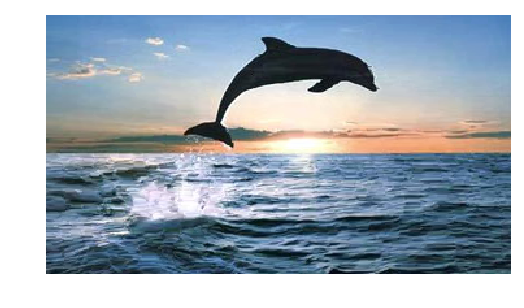

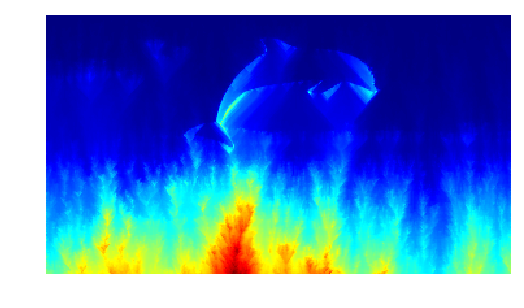

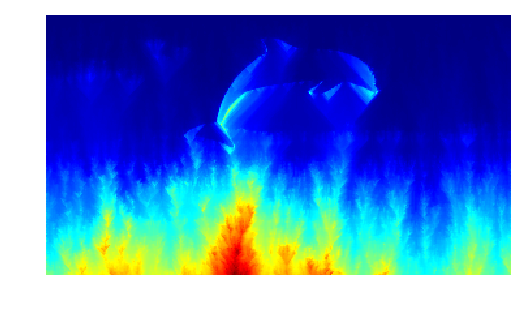

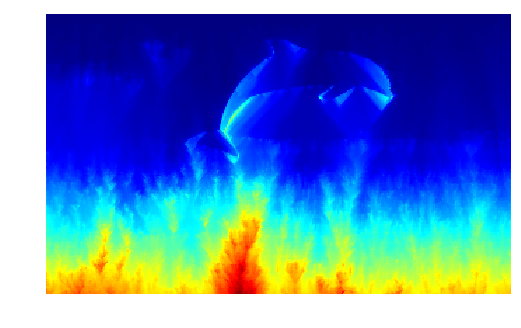

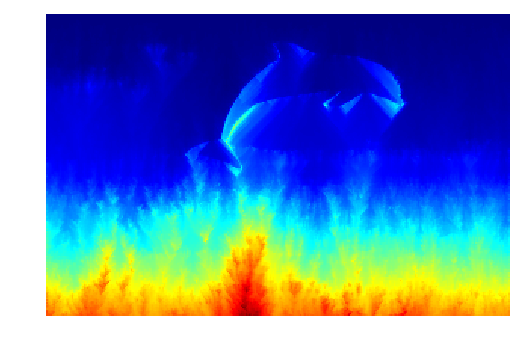

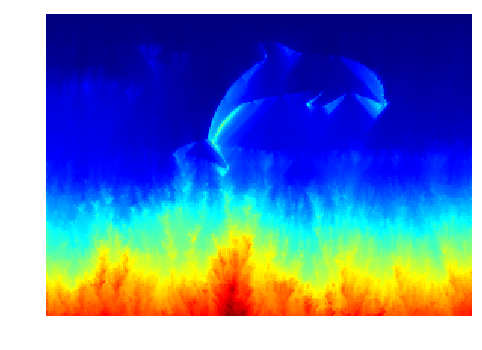

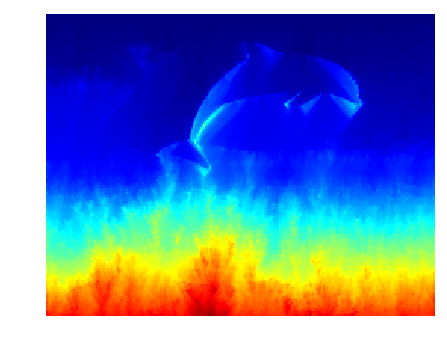

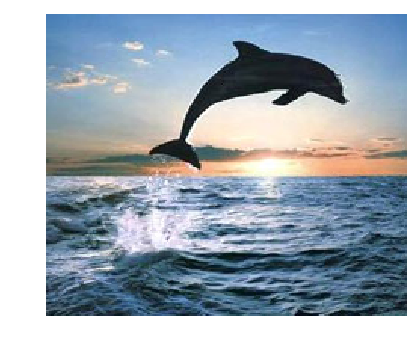

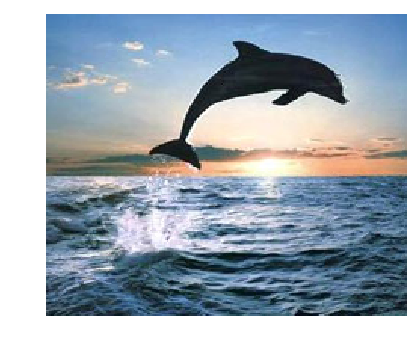

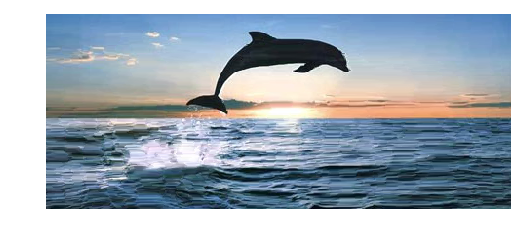

In [23]:
dolphin_fig = cv.imread('images/fig8.png')
dolphin_fig = cv.imread('big_dolphin.png')
#dolphin_fig = cv.imread('images/fig9-2008.png')
#island_fig = cv.imread('images/fig5.png')
#dolphin_fig= cv.GaussianBlur(dolphin_fig, (3, 3), 0, 0, cv.BORDER_DEFAULT)
original_image = np.copy(dolphin_fig)
dolphin_fig = add_seams(dolphin_fig,119)
cv.imwrite("scaled_up_seams.png",dolphin_fig)

#dolphin_fig = cv.imread('images/fig8-2008.png')
#dolphin_fig = add_seams(dolphin_fig,119)
#cv.imwrite("scaled_up_seams2x.png",dolphin_fig)

#image_with_seams = draw_seams(original_image)
#display_image(image_with_seams)
#cv.imwrite("image_with_seams.png",image_with_seams)

#scaled_image = add_seams(dolphin_fig,119)
#display_image(scaled_image)
#v.imwrite("scaled_image.png",scaled_image.astype(np.uint8))

#heatmap_generated = False

#carve_seams(scaled_image)
#scaled_image2x = add_seams(scaled_image,119)
#display_image(scaled_image)
#cv.imwrite("scaled_image2x.png",scaled_image2x.astype(np.uint8))
#image_with_seams = draw_seams(scaled_image)
#cv.imwrite("image_with_seams.png",image_with_seams)

In [24]:
image_with_seams = draw_seams(original_image)
display_image(image_with_seams)
cv.imwrite("image_with_seams2.png",image_with_seams)

IndexError: index 358 is out of bounds for axis 0 with size 358

In [ ]:
#print(big_dolphin.dtype)

In [ ]:
#display_image(get_sobel(cv.cvtColor(dolphin_fig,cv.COLOR_BGR2GRAY)))

In [ ]:
#cv.imwrite("scaled_image.png",scaled_image.astype(np.uint8))